In [1]:

import time

import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import numpy as np
import pymysql
import traceback2
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

top_symbols_count = 1100

In [2]:



def read_csv_as_df():
    df = pd.read_csv('/tmp/coins_data.csv')
    df.index = pd.DatetimeIndex(df['time'])
    del df['time']
    df = df[df.index >= datetime(2020, 12, 26)]
    return df


def __connect__():
    db_user = 'coin'
    db_password = 'dragonstone#123'
    db_name = 'master_data'
    db_host = 'localhost'
    return pymysql.connect(
        unix_socket=None,
        host=db_host,
        user=db_user,
        password=db_password,
        db=db_name,
        charset='latin1',
        cursorclass=pymysql.cursors.DictCursor)


def get_cursor(connection):
    if connection is None:
        connection = __connect__()
    connection.ping(reconnect=True)
    return connection.cursor()


def insert_defi_neg_div_score(df, date):
    connection = __connect__()
    cursor = get_cursor(connection)
    dt = date.timestamp()
    for i, row in df.iterrows():
        try:
            sys_name = row["Symbol"]
            name = sys_name.split("###")[1]
            symbol = sys_name.split("###")[0]
            print(dt, date, symbol, name, row['C_Price'], row['3_Day_LB'], row['5_Day_LB'])
            sql = "INSERT INTO `coingecko_defi_neg_div_score` (`timestamp_dt`, `symbol`, `name`, `price`, `3_Day_LB`, `5_Day_LB`) VALUES (FROM_UNIXTIME(%s), %s, %s, %s, %s, %s)"
            cursor.execute(sql, (dt, symbol, name, row['C_Price'], row['3_Day_LB'], row['5_Day_LB']))
        except Exception:
            print(traceback2.format_exc())
    connection.commit()
    cursor.close()
    connection.close()


def clean_data(df):
    index = df.index.values
#     print(index)
    if 'USDT' in index:
        del df['USDT']
    if 'USDC' in index:
        del df['USDC']
    if 'DAI' in index:
        del df['DAI']
    if 'BUSD' in index:
        del df['BUSD']
    if 'HUSD' in index:
        del df['HUSD']
    if 'TUSD' in index:
        del df['TUSD']
    if 'BTC' in index:
        del df['BTC']
    data_values_df = pd.DataFrame(df.isna().sum(), columns=['nan_count'])
    tmp_df = pd.DataFrame(df.count(), columns=['values_count'])
    data_values_df['values_count'] = tmp_df['values_count']
    data_values_df['rows_count'] = data_values_df['values_count'] + data_values_df['nan_count']
#     print(data_values_df)
    delete_coin_df = data_values_df[data_values_df['nan_count'] > (data_values_df['values_count'] * .20)]
    delete_coin_df.sort_values(['nan_count'])
    symbols_del = delete_coin_df.index.tolist()
    print(symbols_del)
    print(len(symbols_del))
    for symbol in symbols_del:
        print(f'Deleteing Coin: {symbol}')
        del df[symbol]
    df.ffill(inplace=True)
    df = df.dropna(axis=1)
    df.index = df.index
    return df


def get_todays_portfolio_balance(trades):
    balance = 0
    for symbol in trades:
        balance = balance + trades[symbol][3]
    return balance


def make_entry_symbol(df, trading_date, symbol, last_trade, fund):
    last_trade = last_trade.copy()
    todays_close = get_close_price_on(df, symbol, trading_date)
    if not len(last_trade):
        last_trade = [trading_date, todays_close, fund / todays_close, fund, 0]
        return last_trade
    last_trade[0] = trading_date
    last_trade[1] = todays_close
    last_trade[3] = last_trade[2] * todays_close
    last_trade[4] = last_trade[4] + 1
#     print(last_trade)
    return last_trade


def make_exit_symbol(df, trading_date, symbol, last_trade):
    quantity = last_trade[2]
    todays_close = get_close_price_on(df, symbol, trading_date)
    return quantity * todays_close


def get_not_in_list(new_list, old_list):
    not_in_new = []
    for symbol in old_list:
        if symbol not in new_list:
            not_in_new.append(symbol)
    return not_in_new


def get_commons(symbols1, symbols2):
    symbols_list = []
    for symbol in symbols2:
        if symbol in symbols1:
            symbols_list.append(symbol)
    return symbols_list


def get_joins(symbols1, symbols2):
    symbols_list = symbols1.copy()
    for symbol in symbols2:
        if symbol not in symbols1:
            symbols_list.append(symbol)
    return symbols_list


def get_todays_top_n_coin(df, trade_date, top_n, order='tail'):
    data = df.loc[trade_date]
    data = pd.DataFrame(data)
    data = data.rename(columns={data.columns[0]: 'C'})
    todays_close_df = pd.DataFrame(data)
    if order == 'head':
        todays_close_df = todays_close_df.sort_values(['C']).head(top_n)
    else:
        todays_close_df = todays_close_df.sort_values(['C']).tail(top_n)
    return todays_close_df.index.values.tolist()


def get_next_trading_day_as_index(start_date, hour):
    return pd.to_datetime((start_date + timedelta(days=1)).replace(hour=hour, minute=0, second=0).strftime("%Y %m %d %H:%M:00"))


def get_close_price_on(df, symbol, trade_date):
    data = df.loc[trade_date]
    data = pd.DataFrame(data)
    data = data.rename(columns={data.columns[0]: 'C'})
    todays_close_df = pd.DataFrame(data)
    try:
        return todays_close_df.loc[symbol]['C']
    except Exception:
        return 0


def get_qualified_coins(trade_date, factors_df, factors_count):
    factors_symbols = []
    index = 0
    for factor_df in factors_df:
        s1 = get_todays_top_n_coin(factor_df, trade_date, factors_count[index])
        index = index + 1
        factors_symbols.append(s1)
    symbols = factors_symbols[0]
    for index in range(1, len(factors_symbols)):
        symbols = get_commons(symbols, factors_symbols[index])
    return symbols


def update_coins_performance(coins_performence, todays_trading_symbols):
    symbol_performance = [0, 0]
    for symbol in todays_trading_symbols:
        if symbol in coins_performence:
            symbol_performance = coins_performence[symbol]
        else:
            symbol_performance = [0, 0]
            coins_performence[symbol] = symbol_performance
        symbol_performance[0] = symbol_performance[0] + 1


def update_total_days_count_in_coin_performance(coins_performence, days_count):
    for symbol in coins_performence:
        coins_performence[symbol][1] = days_count


def plot_portfolio_performence(trade_date, df, factors_df, factors_count):
    trades = {}
    trades['c-f'] = [trade_date, 0, 0, 0]
    last_day_trading_symbols = []
    is_first_day_trading = True
    portfolio_performence = []
    end_time = df.index.values.max()
    end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    coins_performence = {}
    days_count = 0
    while trade_date.timestamp() < end_time:
        days_count = days_count + 1
        todays_trading_symbols = get_qualified_coins(trade_date, factors_df, factors_count)
        update_coins_performance(coins_performence, todays_trading_symbols)
        if is_first_day_trading:
            is_first_day_trading = False
            if not len(todays_trading_symbols):
                trades['c-f'][3] = 100000
                continue
            fund = 100000 / len(todays_trading_symbols)
            for symbol in todays_trading_symbols:
                trade = make_entry_symbol(df, trade_date, symbol, [], fund)
                trades[symbol] = trade
#             is_first_day_trading = False
            last_day_trading_symbols = todays_trading_symbols.copy()
            continue
        tmp_trades = trades

        trades = {}
        exit_fund = tmp_trades['c-f'][3]
        todays_exit_symbols = get_not_in_list(todays_trading_symbols, last_day_trading_symbols)
        todays_common_symbols = get_commons(todays_trading_symbols, last_day_trading_symbols)
        todays_new_entry_symbols = get_not_in_list(todays_common_symbols, todays_trading_symbols)

        new_symbol = []
        for symbol_c in todays_common_symbols:
            trade = tmp_trades[symbol_c]
            if trade[4] > 5:
                exit_fund = exit_fund + make_exit_symbol(df, trade_date, symbol_c, trade)
                if symbol_c in todays_trading_symbols:
                    todays_new_entry_symbols.append(symbol_c)
                continue
            trade = make_entry_symbol(df, trade_date, symbol_c, trade, 0)
            trades[symbol_c] = trade

        for exit_symbol in todays_exit_symbols:
            exit_trade = tmp_trades[exit_symbol]
            fund = make_exit_symbol(df, trade_date, exit_symbol, exit_trade)
            exit_fund = exit_fund + fund
        if len(todays_new_entry_symbols):
            new_entry_fund = exit_fund / len(todays_new_entry_symbols)
            exit_fund = 0
            for entry_symbol in todays_new_entry_symbols:
                trade = make_entry_symbol(df, trade_date, entry_symbol, [], new_entry_fund)
                trades[entry_symbol] = trade
                new_symbol.append(entry_symbol)
        tmp_trades['c-f'][3] = exit_fund
        tmp_trades['c-f'][0] = trade_date
        trades['c-f'] = tmp_trades['c-f']
#         if tmp_trades['c-f'][3] > 0:
#             print(f"Uninvested amount as on {tmp_trades['c-f'][0]} is {tmp_trades['c-f'][3]}")
        portfolio_performence.append([get_todays_portfolio_balance(trades), trade_date])
        trade_date = get_next_trading_day_as_index(trade_date, trade_date.hour)
        last_day_trading_symbols = get_joins(todays_common_symbols, new_symbol)
    update_total_days_count_in_coin_performance(coins_performence, days_count)
    print(f'Last Trading Day: {trade_date}. Currently Coins in Portfolio: \n {todays_trading_symbols}')
    return [portfolio_performence, todays_trading_symbols, coins_performence]


def plot_portfolio_for_config(close_df, factors_pct, factors_df):
    total_symbols_count = len(close_df.columns.values.tolist())
    factors_count = []
    for factor_pct in factors_pct:
        factors_count.append(int(total_symbols_count / 100 * factor_pct))

    start_time = factors_df[0].index.values.min()
    start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    start_time = datetime.utcfromtimestamp(start_time_secs)
    trade_date = start_time + timedelta(days=0)
    trade_date = get_next_trading_day_as_index(trade_date, trade_date.hour)
    print(f'Trading Start Date: {trade_date}')
    portfolio = plot_portfolio_performence(trade_date, close_df, factors_df, factors_count)
    portfolio_performence = portfolio[0]
    performance_df = pd.DataFrame(portfolio_performence, columns=['balance', 'time'])
    performance_df.index = pd.DatetimeIndex(performance_df['time'])
    del performance_df['time']
    performance_df.plot(figsize=[18, 10])
#     plt.savefig(f'/tmp/portfolio_{"_".join(str(x) for x in factors_pct)}.png')

    print(f'Current Portfilio Balance: {portfolio_performence[-1][0]}')
    return portfolio[1:]


def get_rsq(x):
    X = x.values.reshape(-1, 1)
    Y = np.arange(1, len(X) + 1).reshape(-1, 1)
    linear_regressor = LinearRegression(fit_intercept=True)
    linear_regressor.fit(Y, X)
    return linear_regressor.score(Y, X)
#     return r2_score(Y, X)


def get_portfolio_version_coins(close_df, factors_df):
    # factors_df = [_7_days_pct_change_df, _days_sumed_pct_change_df, _6_hour_rsq_df, _pure_div_score]
    factors = [25, 10, 10, 99]
    coins_performance = plot_portfolio_for_config(close_df, factors, factors_df)
    coin_performance_df = pd.DataFrame.from_dict(coins_performance[1], orient='index', columns=['Occurrences', 'Total Trading Day'])
    coin_performance_df = coin_performance_df.sort_values(['Occurrences'], ascending=True)
#     coin_performance_df.to_csv(f'/tmp/portfolio_{"_".join(str(x) for x in factors)}_coin_performance.csv')
    s1 = coins_performance[0]
    factors = [25, 99, 50, 7.5]
    coins_performance = plot_portfolio_for_config(close_df, factors, factors_df)
    coin_performance_df = pd.DataFrame.from_dict(coins_performance[1], orient='index', columns=['Occurrences', 'Total Trading Day'])
    coin_performance_df = coin_performance_df.sort_values(['Occurrences'], ascending=True)
#     coin_performance_df.to_csv(f'/tmp/portfolio_{"_".join(str(x) for x in factors)}_coin_performance.csv')
    s2 = coins_performance[0]
    return get_joins(s1, s2)


def run_portfolio_version(close_df, factors_df, _6_hour_resampled_df, day):
    _7_days_pct_change_df = _6_hour_resampled_df.pct_change(periods=day * 4)
    factors_df[0] = _7_days_pct_change_df
    return get_portfolio_version_coins(close_df, factors_df)


def get_coins_price(close_df, symbols):
    df = close_df.iloc[[-1]]
    symbols_price = f"As On {df.index.values[0]}<br>"
    for symbol in symbols:
        symbols_price = f'{symbols_price} {symbol}: ${df.iloc[0][symbol]},'
    return symbols_price


def get_lookback_df(close_df, lookback_symbols):
    close_df = close_df.iloc[[-1]]
    symbols = []
    for lookback in lookback_symbols:
        symbols = get_joins(symbols, lookback_symbols[lookback])
    data = []
    for symbol in symbols:
        data.append([
            symbol,
            close_df.iloc[0][symbol],
            symbol in lookback_symbols[3],
            symbol in lookback_symbols[5]
        ])
    df = pd.DataFrame(data, columns=['Symbol', 'C_Price', '3_Day_LB', '5_Day_LB'])
    return df


def run_algo(close_df):
    _6_hour_resampled_df = close_df.resample('6H').last()
    _6_hour_pct_change = _6_hour_resampled_df.pct_change(periods=1)
    _days_sumed_pct_change_df = _6_hour_pct_change.rolling(window=4).sum()
    _pure_div_score = _6_hour_pct_change.applymap(lambda x: x if x < 0 else 0)
    _pure_div_score = _pure_div_score.rolling(window=4).sum()
    _6_hour_rsq_df = _6_hour_resampled_df.rolling(window=28).apply(get_rsq)
    factors_df = [None, _days_sumed_pct_change_df, _6_hour_rsq_df, _pure_div_score]
    # return run_portfolio_version(close_df, factors_df, _6_hour_resampled_df, 7)
    days = [3, 4, 5, 7]
    msg = ""
    lookback_symbols = {}
    for day in days:
        msg = f'{msg}<br> {day}-day Lookback. <br>Coins Symbol in Portfolio are as below:<br>'
        symbols = run_portfolio_version(close_df, factors_df, _6_hour_resampled_df, day)
        lookback_symbols[day] = symbols
        msg = f'{msg} {get_coins_price(close_df, symbols)}<br><br>'
    lookback_df = get_lookback_df(close_df, lookback_symbols)
    return lookback_df


def delete_unnessecary_columns(df):
    df = df.drop_duplicates(keep='first')
    return df


def convert_symbols_to_columns(df):
    df = df.pivot(columns='symbol', values='C')
    return df


def get_symbols_close(ids):
    connection = __connect__()
    s = ",".join([f'"{s}"' for s in ids])
    sql = f"select * from coingecko_coin_hist_data where id in ({s})"
    df = pd.read_sql(sql, connection)
    connection.close()
    return df


def get_symbols_close_data_df(ids):
#     ids = data_df['Symbol'].unique().tolist()
    df = get_symbols_close(ids)
    df = df.drop_duplicates()
    df['sym-name'] = df['symbol'] + '###' + df['name']
    df['symbol'] = df['sym-name']
    df['C'] = df['price']
    df = df[['symbol', 'C', 'timestamp_dt']].copy()
    df['timestamp_dt'] = pd.to_datetime(df['timestamp_dt'])
    df.index = pd.DatetimeIndex(df['timestamp_dt'])
    df.index = df.index
    df = df[df.index >= datetime(2021, 3, 3)]
    df = delete_unnessecary_columns(df)
    df = convert_symbols_to_columns(df)
    return df

def get_market_data(page):
    market_data = cg.get_coins_markets(vs_currency="usd", page=page, per_page=250)
    ids = []
    for data in market_data:
        ids.append(data['id'])
    print(len(ids))
    return ids

def get_top_n_coins_symbol(n):
    page = 0
    totla_downloaded = 0
    rows = []
    while totla_downloaded < n:
        page = page + 1
        data = get_market_data(page)
        if not len(data):
            break
        totla_downloaded = totla_downloaded + len(data)
        rows.extend(data)
        time.sleep(1)
    rows = rows[0:n]
    print(rows)
    return rows

def run_backtest(close_df):
    df = clean_data(close_df)
    print("Data Shape: ", df.shape)
    print(f'1st Trading Day: {df.index.min()}. Last Trading Day: {df.index.max()}')
    symbols_neg_div_df = run_algo(df)
    return symbols_neg_div_df


def generate_defi_neg_div_score(top_symbols_count):
    top_symbols = get_top_n_coins_symbol(top_symbols_count)
    close_df = get_symbols_close_data_df(top_symbols)
    symbols_neg_div_df = run_backtest(close_df)
    return symbols_neg_div_df


250
250
250
250
250
['bitcoin', 'ethereum', 'tether', 'binancecoin', 'cardano', 'dogecoin', 'ripple', 'usd-coin', 'polkadot', 'binance-usd', 'bitcoin-cash', 'litecoin', 'uniswap', 'solana', 'chainlink', 'ethereum-classic', 'matic-network', 'wrapped-bitcoin', 'theta-token', 'stellar', 'internet-computer', 'vechain', 'dai', 'filecoin', 'tron', 'shiba-inu', 'monero', 'eos', 'cosmos', 'aave', 'crypto-com-chain', 'okb', 'bitcoin-cash-sv', 'amp-token', 'algorand', 'celsius-degree-token', 'terra-luna', 'pancakeswap-token', 'compound-ether', 'neo', 'klay-token', 'cdai', 'tezos', 'compound-usd-coin', 'leo-token', 'ftx-token', 'iota', 'theta-fuel', 'maker', 'avalanche-2', 'safemoon', 'terrausd', 'decred', 'thorchain', 'huobi-token', 'kusama', 'bittorrent-2', 'waves', 'the-graph', 'hedera-hashgraph', 'compound-governance-token', 'true-usd', 'elrond-erd-2', 'zcash', 'dash', 'sushi', 'telcoin', 'huobi-btc', 'chiliz', 'staked-ether', 'yearn-finance', 'nem', 'helium', 'havven', 'holotoken', 'zilliqa'

<ipython-input-2-d381f5e3c174>:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDT' in index:
<ipython-input-2-d381f5e3c174>:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDC' in index:
<ipython-input-2-d381f5e3c174>:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'DAI' in index:
<ipython-input-2-d381f5e3c174>:59: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'BUSD' in index:
<ipython-input-2-d381f5e3c174>:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'HUSD' in index:
<ipython-input-2-d381f5e3c174>:63: FutureWarning: elementwise comparison failed; retur

['10SET###Tenset', 'ABLOCK###ANY Blocknet', 'AETH###ankrETH', 'AGA###AGA Token', 'AGI###SingularityNET', 'AGIX###SingularityNET', 'AIOZ###AIOZ Network', 'ALIAS###Alias', 'ALUSD###Alchemix USD', 'ANJ###Aragon Court', 'ATA###Automata', 'AUSCM###Auric Network', 'AWX###AurusDeFi', 'BANANA###ApeSwap Finance', 'BANK###Bankless DAO', 'BBR###Bitberry Token', 'BCDT###Blockchain Certified Data Token', 'BCDT###EvidenZ', 'BDI###BasketDAO DeFi Index', 'BDT###BlackDragon Token', 'BECN###Beacon', 'BOO###Spookyswap', 'BOR###BoringDAO [OLD]', 'BORING###BoringDAO', 'BOS###BOScoin', 'BOSON###Boson Protocol', 'BTC2###Bitcoin 2', 'BTC2X-FLI###BTC 2x Flexible Leverage Index', 'BTCP###Bitcoin Private', 'BUY###Burency', 'BWF###Beowulf', 'CARDS###Cardstarter', 'CATE###CateCoin', 'CBC###CBC.network', 'CHI###XAYA', 'COL###Unit Protocol', 'CONV###Convergence', 'COPE###Cope', 'COPS###Cops Finance', 'CQT###Covalent', 'CRETH2###Cream ETH 2', 'CSPR###Casper Network', 'CTT###CryptoTycoon', 'CTXC###Cortex', 'CUMMIES###

Deleteing Coin: GYEN###GYEN
Deleteing Coin: GZIL###governance ZIL
Deleteing Coin: HAPI###HAPI
Deleteing Coin: HOTCROSS###Hot Cross
Deleteing Coin: IBBTC###Interest Bearing Bitcoin
Deleteing Coin: ICE###Popsicle Finance
Deleteing Coin: ICP###Internet Computer
Deleteing Coin: IDV###Idavoll Network
Deleteing Coin: ILV###Illuvium
Deleteing Coin: INST###Instadapp
Deleteing Coin: IOC###I/O Coin
Deleteing Coin: ION###ION
Deleteing Coin: ION###Ion
Deleteing Coin: JUR###Jur
Deleteing Coin: KALM###Kalmar
Deleteing Coin: KEANU###Keanu Inu
Deleteing Coin: KIRO###Kirobo
Deleteing Coin: KNC###Kyber Network Crystal
Deleteing Coin: KOGE###BNB48 Club Token
Deleteing Coin: KOIN###Koinos
Deleteing Coin: KTN###Kattana
Deleteing Coin: KUB###Bitkub Coin
Deleteing Coin: KUMA###Kuma Inu
Deleteing Coin: LEND###Aave [OLD]
Deleteing Coin: LITH###Lith Token
Deleteing Coin: LMT###Lympo Market Token
Deleteing Coin: LND###Lendingblock
Deleteing Coin: LQTY###Liquity
Deleteing Coin: LUSD###Liquity USD
Deleteing Coin: 

<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Trading Start Date: 2021-03-04 00:00:00
Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['SHIB###Shiba Inu', 'BCHA###Bitcoin Cash ABC', 'TXL###Tixl', 'GAS###Gas']
Current Portfilio Balance: 15253336.786298223
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['KAVA###Kava.io', 'REP###Augur', 'TROY###Troy', 'ARK###Ark', 'SWINGBY###Swingby', 'AXS###Axie Infinity', 'SNT###Status', 'CVC###Civic', 'PHA###Phala Network', 'CRU###Crust Network', 'DCR###Decred', 'SYLO###Sylo', 'KOBE###Shabu Shabu', 'LCC###Litecoin Cash', 'FWT###Freeway Token']
Current Portfilio Balance: 23525503.044230793
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['SHIB###Shiba Inu', 'BCHA###Bitcoin Cash ABC', 'TXL###Tixl']
Current Portfilio Balance: 14502877.344940318
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['KAVA###Kava.io', 'REP###Augur', 'TROY###Troy', 'ARK###Ark', 'SWINGBY###Swingby', 'AXS###Axie Infinity', 'SNT###Status', 'CVC###Civic', 'PHA###Phala Network', 'DCR###Decred', 'SYLO###Sylo', 'KOBE###Shabu Shabu', 'LCC###Litecoin Cash', 'FWT###Freeway Token', 'SDX###SwapDEX']
Current Portfilio Balance: 71802298.95714071
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['SHIB###Shiba Inu', 'BCHA###Bitcoin Cash ABC', 'TXL###Tixl', 'GAS###Gas']
Current Portfilio Balance: 13906289.358400065
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['WAVES###Waves', 'KAVA###Kava.io', 'REP###Augur', 'TROY###Troy', 'SWINGBY###Swingby', 'AXS###Axie Infinity', 'SNT###Status', 'CVC###Civic', 'PHA###Phala Network', 'CRU###Crust Network', 'DCR###Decred', 'NSBT###Neutrino System Base Token', 'SYLO###Sylo', 'KOBE###Shabu Shabu', 'LCC###Litecoin Cash', 'FWT###Freeway Token', 'SDX###SwapDEX']
Current Portfilio Balance: 28326982.639798068
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['SHIB###Shiba Inu', 'BCHA###Bitcoin Cash ABC', 'TXL###Tixl', 'GAS###Gas']
Current Portfilio Balance: 13882353.478299169
Trading Start Date: 2021-03-04 00:00:00


<ipython-input-2-d381f5e3c174>:269: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-2-d381f5e3c174>:200: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-07-01 00:00:00. Currently Coins in Portfolio: 
 ['WAVES###Waves', 'KAVA###Kava.io', 'REP###Augur', 'TROY###Troy', 'ARK###Ark', 'SWINGBY###Swingby', 'AXS###Axie Infinity', 'SNT###Status', 'CVC###Civic', 'ZMT###Zipmex Token', 'PHA###Phala Network', 'CRU###Crust Network', 'DCR###Decred', 'NSBT###Neutrino System Base Token', 'SYLO###Sylo', 'KOBE###Shabu Shabu', 'LCC###Litecoin Cash', 'FWT###Freeway Token']
Current Portfilio Balance: 27332278.336339667


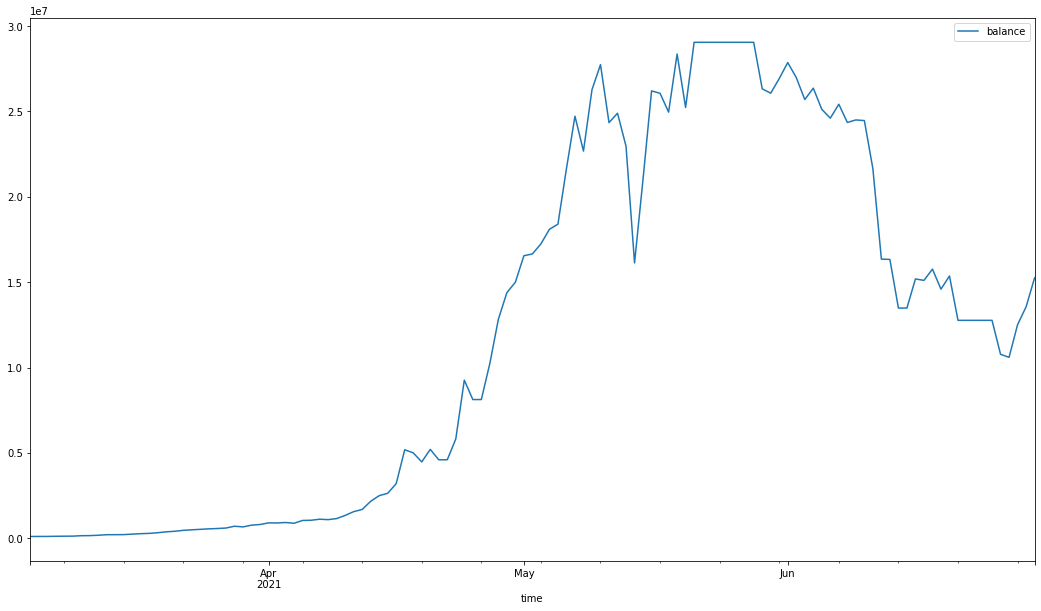

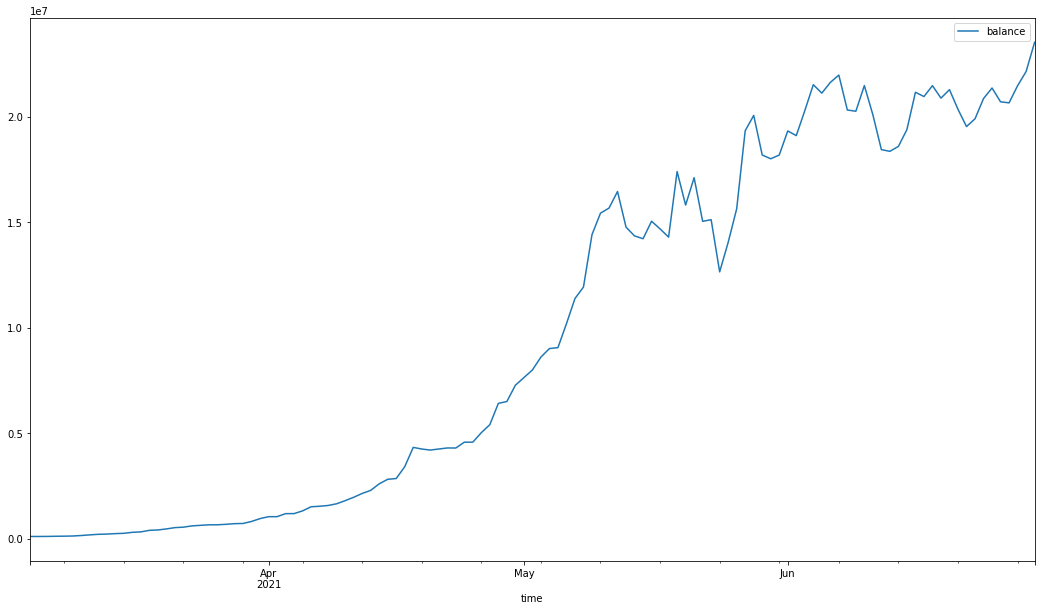

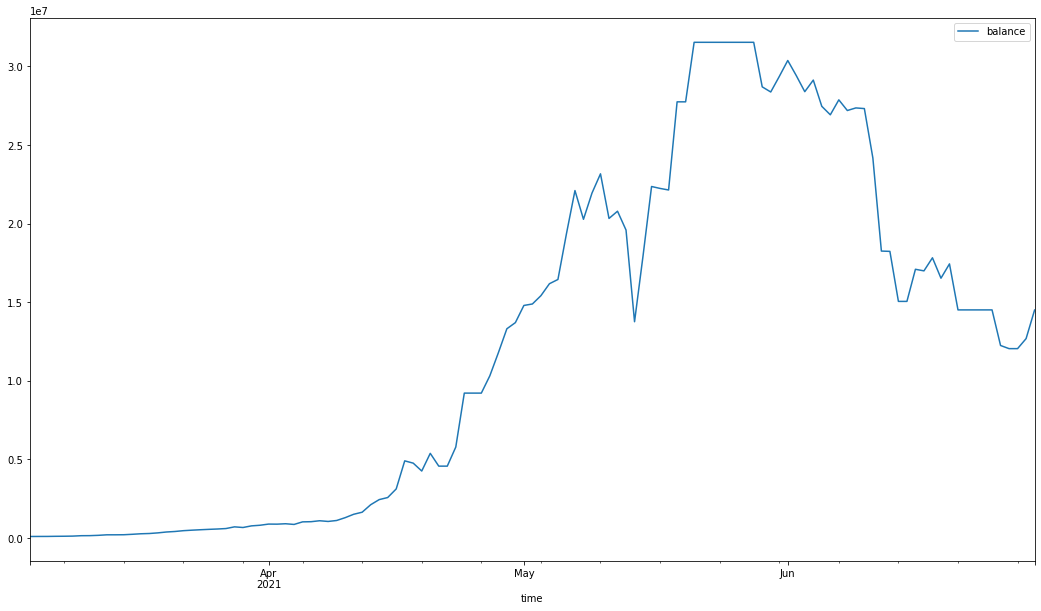

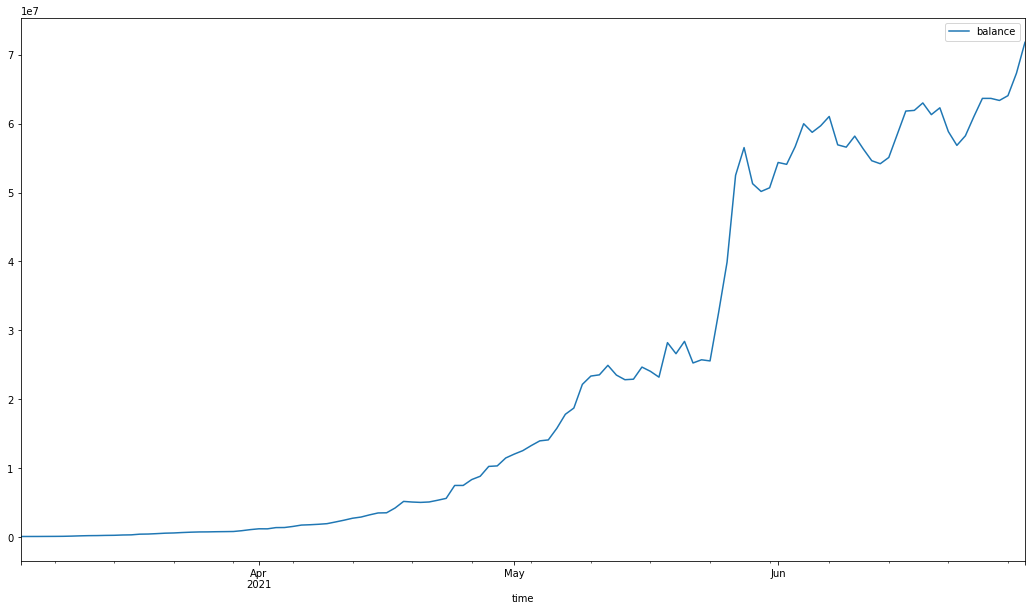

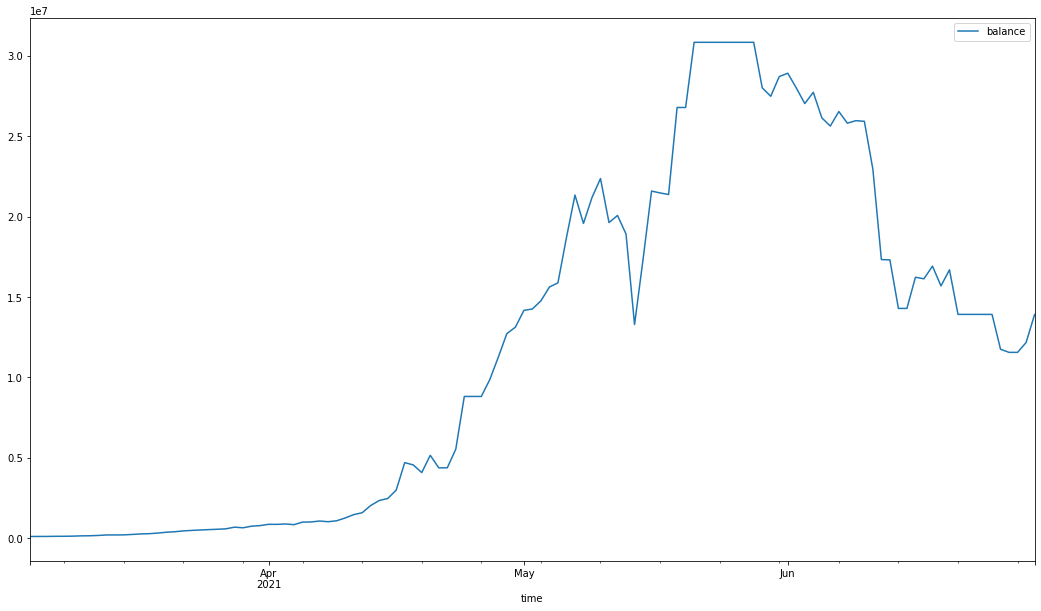

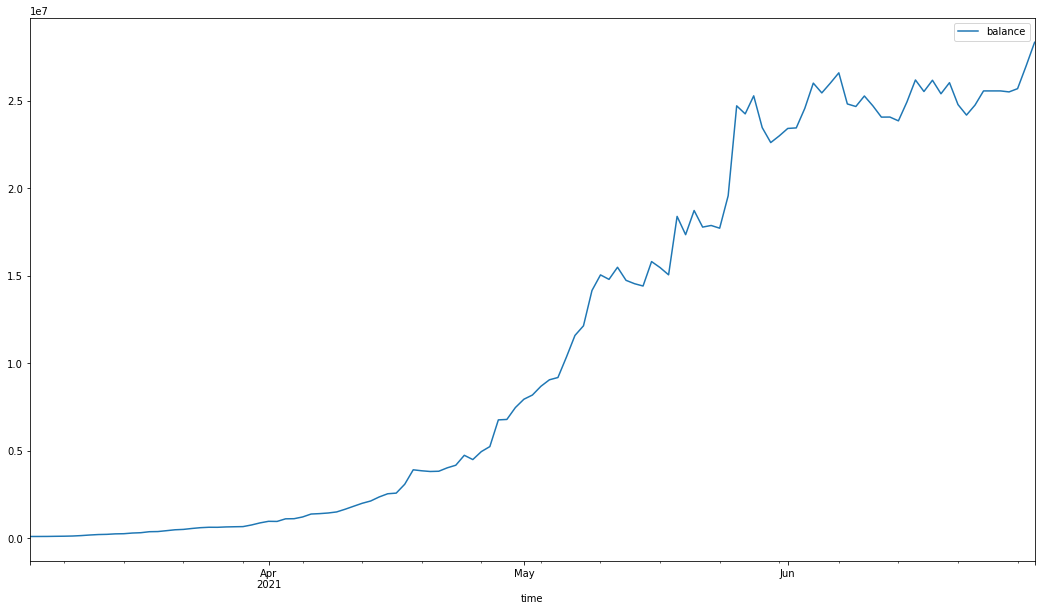

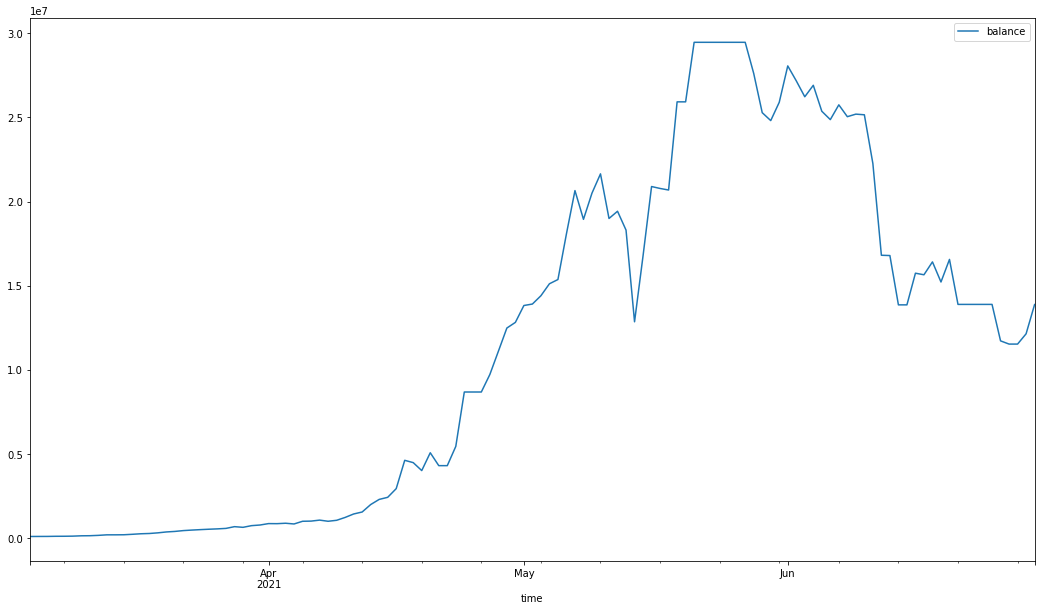

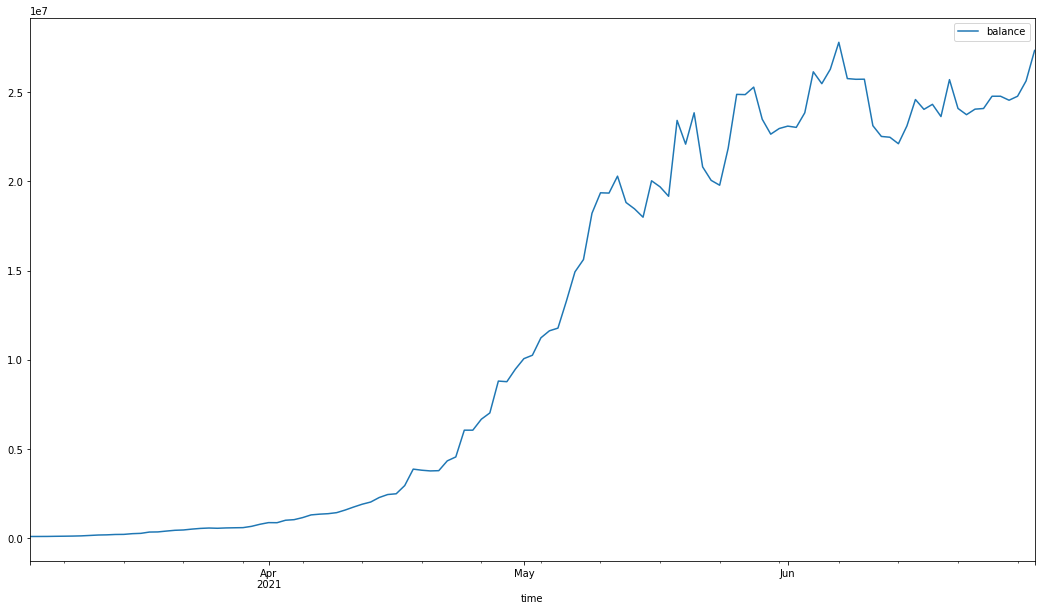

In [3]:

top_symbols_defi_report = generate_defi_neg_div_score(top_symbols_count)

In [4]:
top_symbols_defi_report

,Symbol,C_Price,3_Day_LB,5_Day_LB
0,SHIB###Shiba Inu,0.000009,True,True
1,BCHA###Bitcoin Cash ABC,33.847274,True,True
2,TXL###Tixl,0.187187,True,True
3,GAS###Gas,6.079503,True,True
4,KAVA###Kava.io,4.095536,True,True
5,REP###Augur,15.083677,True,True
6,TROY###Troy,0.008339,True,True
7,ARK###Ark,0.874268,True,False
8,SWINGBY###Swingby,0.080044,True,True
9,AXS###Axie Infinity,5.343586,True,True


In [6]:
top_symbols_defi_report.to_csv("gecko_neg_div.csv")